# Light Curves from Lauren macArthur applied to November/december visits at AuxTel, Using Spectro Data

- creation date 2024-03-12
- last update 2024-03-12
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399

 

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle

In [2]:
saveDir = "./lc_output_auxtelfall2023_spectro"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [3]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux = 50  # 100

In [4]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
# collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648"
collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"

collectionStr = collection.replace("/", "_")
instrument = "LATISS"
skymapName = "latiss_v1"
#band = "i"
#tract = 5615
band = "y"
tract = 3864

calibFluxStr = "apFlux_35_0_instFlux"

file_output_selectedsources = f"lightcurves-selectedsources_tract{tract}_band{band}_novdec2023.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Selected Visits and Selected Nights

In [5]:
file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"
file_selected_nights = "AuxtelSpectroData/AtmParamPerNightObsDict_fall2023.pkl"

In [6]:
df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)
my_selectedvisits = list(df_myselectedvisits.index)

In [7]:
#move the visitid as a column not to loose it during the merge 
df_myselectedvisits.reset_index(inplace=True) 

In [8]:
df_myselectedvisits

,visitId,nightObs,physical_filter,band,zeroPoint,expMidptMJD,obsStart,obsStartMJD,Time,airmass,patchID,tractID
0,2023112100506,20231121,SDSSg_65mm~empty,g,28.037330,60270.293207,2023-11-22 07:01:58.064996,60270.293033,2023-11-22 07:01:58.064996,1.087878,3864,237
1,2023112100507,20231121,SDSSr_65mm~empty,r,27.826233,60270.293745,2023-11-22 07:02:44.576007,60270.293571,2023-11-22 07:02:44.576007,1.086620,3864,237
2,2023112100508,20231121,SDSSz_65mm~empty,z,27.281532,60270.294284,2023-11-22 07:03:31.156006,60270.294111,2023-11-22 07:03:31.156006,1.085371,3864,237
3,2023112100509,20231121,empty~SDSSy_65mm,y,26.175438,60270.294842,2023-11-22 07:04:19.313506,60270.294668,2023-11-22 07:04:19.313506,1.084094,3864,237
4,2023112100510,20231121,SDSSg_65mm~empty,g,28.049168,60270.295844,2023-11-22 07:05:45.944508,60270.295671,2023-11-22 07:05:45.944508,1.081935,3864,236
...,...,...,...,...,...,...,...,...,...,...,...,...
871,2023122200530,20231222,empty~SDSSy_65mm,y,26.290860,60301.274438,2023-12-23 06:34:56.432498,60301.274264,2023-12-23 06:34:56.432498,1.006569,3864,236
872,2023122200531,20231222,SDSSg_65mm~empty,g,28.088020,60301.275506,2023-12-23 06:36:28.743997,60301.275333,2023-12-23 06:36:28.743997,1.006333,3864,236
873,2023122200532,20231222,SDSSr_65mm~empty,r,27.858763,60301.276044,2023-12-23 06:37:15.228995,60301.275871,2023-12-23 06:37:15.228995,1.006219,3864,236
874,2023122200533,20231222,SDSSz_65mm~empty,z,27.357218,60301.276586,2023-12-23 06:38:02.021494,60301.276412,2023-12-23 06:38:02.021494,1.006114,3864,236


In [9]:
# Check the night selected
df_myselectedvisits['nightObs'].unique()

array([20231121, 20231127, 20231128, 20231129, 20231130, 20231204,
       20231205, 20231206, 20231211, 20231214, 20231215, 20231220,
       20231221, 20231222])

### Make the dataframe holding the atmospheric parameters

In [10]:
df_selnight = pd.DataFrame(columns=('nightObs', 'PWV', 'VAOD','Grey',"Ozone"))
with open(file_selected_nights, 'rb') as fp:
    selectedNightsDict  = pickle.load(fp)
idx=0
for key,value in selectedNightsDict.items():
    pwv = value['median']['median_param_atm']['md_PWV']
    vaod = value['median']['median_param_atm']['md_VAOD']
    grey = value['median']['median_param_atm']['md_grey']
    ozone = value['median']['median_param_atm']['md_ozone']
    df_selnight.loc[idx] = [int(key),pwv,vaod,grey,ozone]
    idx+=1

In [11]:
# Convert the nightObs as an integer
df_selnight = df_selnight.astype({'nightObs':'int'})

In [12]:
df_night_to_atm = df_selnight.copy().set_index('nightObs')

In [13]:
df_night_to_atm

,PWV,VAOD,Grey,Ozone
nightObs,,,,
20230927,1.360643,0.006606,0.962204,322.459010
20230928,2.172185,0.000000,0.957690,309.241099
20231010,2.323852,0.006589,0.963656,328.488524
20231107,2.101962,0.013239,0.972018,304.659232
20231113,2.547404,0.009443,0.962289,339.184216
20231114,2.880052,0.009948,0.966162,322.515609
20231115,2.577242,0.002186,0.948540,317.834236
20231116,2.297691,0.006841,0.949698,348.357957
20231120,2.599672,0.017588,0.984415,315.151618


In [14]:
df_night_to_atm.loc[20231127]

PWV        3.551770
VAOD       0.004201
Grey       0.967583
Ozone    305.884093
Name: 20231127, dtype: float64

In [15]:
df_selnight['nightObs'].unique()

array([20230927, 20230928, 20231010, 20231107, 20231113, 20231114,
       20231115, 20231116, 20231120, 20231127, 20231128, 20231129,
       20231130, 20231204, 20231205, 20231206, 20231207])

## Merge the two dataset

- kepp the intersection

In [16]:
df_merge = df_myselectedvisits.merge(df_selnight, left_on='nightObs',right_on='nightObs',how="inner")

In [17]:
df_merge['nightObs'].unique()

array([20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206])

In [18]:
df_myselectedvisits = df_merge.copy()

In [19]:
df_myselectedvisits

,visitId,nightObs,physical_filter,band,zeroPoint,expMidptMJD,obsStart,obsStartMJD,Time,airmass,patchID,tractID,PWV,VAOD,Grey,Ozone
0,2023112700289,20231127,SDSSg_65mm~empty,g,28.049986,60276.274623,2023-11-28 06:35:12.465999,60276.274450,2023-11-28 06:35:12.465999,1.093019,3864,237,3.551770,0.004201,0.967583,305.884093
1,2023112700290,20231127,SDSSr_65mm~empty,r,27.843603,60276.275165,2023-11-28 06:35:59.225506,60276.274991,2023-11-28 06:35:59.225506,1.091708,3864,237,3.551770,0.004201,0.967583,305.884093
2,2023112700291,20231127,SDSSz_65mm~empty,z,27.314777,60276.275706,2023-11-28 06:36:45.996996,60276.275532,2023-11-28 06:36:45.996996,1.090408,3864,237,3.551770,0.004201,0.967583,305.884093
3,2023112700292,20231127,empty~SDSSy_65mm,y,26.169914,60276.276261,2023-11-28 06:37:33.978497,60276.276088,2023-11-28 06:37:33.978497,1.089088,3864,237,3.551770,0.004201,0.967583,305.884093
4,2023112700293,20231127,SDSSg_65mm~empty,g,28.077412,60276.277268,2023-11-28 06:39:00.978991,60276.277095,2023-11-28 06:39:00.978991,1.086840,3864,237,3.551770,0.004201,0.967583,305.884093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,2023120600314,20231206,empty~SDSSy_65mm,y,26.273216,60285.309672,2023-12-07 07:25:40.656999,60285.309498,2023-12-07 07:25:40.656999,1.009665,3864,236,1.745412,0.007880,0.949152,313.621492
427,2023120600315,20231206,SDSSg_65mm~empty,g,28.086746,60285.310672,2023-12-07 07:27:07.101494,60285.310499,2023-12-07 07:27:07.101494,1.009217,3864,236,1.745412,0.007880,0.949152,313.621492
428,2023120600316,20231206,SDSSr_65mm~empty,r,27.864086,60285.311213,2023-12-07 07:27:53.827494,60285.311040,2023-12-07 07:27:53.827494,1.008973,3864,236,1.745412,0.007880,0.949152,313.621492
429,2023120600317,20231206,SDSSz_65mm~empty,z,27.352793,60285.311755,2023-12-07 07:28:40.619498,60285.311581,2023-12-07 07:28:40.619498,1.008738,3864,236,1.745412,0.007880,0.949152,313.621492


In [20]:
my_selectedvisits = list(df_myselectedvisits.visitId)

In [21]:
df_atm = df_myselectedvisits[["visitId","PWV","VAOD","Grey","Ozone"]]

## Config

In [22]:
# Testing on an HSC RC2 run
# butlerRoot = "/repo/main"
# collection = "HSC/runs/RC2/w_2024_06/DM-42797"

# collectionStr = collection.replace("/", "_")
# instrument = "HSC"
# skymapName = "hsc_rings_v1"
# band = "i"
# tract = 9813

# calibFluxStr = "apFlux_12_0_instFlux"

In [23]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collection, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collection = {}".format(collection))

camera_name = LATISS
collection = LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871


In [24]:
# Try to get the Schema
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collection, where= "instrument='LATISS'")
for i, ref in enumerate(datasetRefs):
    print(i,ref)
    butler_data = butler.get(ref)
    break

if not isinstance(butler_data, pd.core.frame.DataFrame):
    print(butler_data.getSchema())

0 isolated_star_sources@{instrument: 'LATISS', skymap: 'latiss_v1', tract: 383} [sc=DataFrame] (run=LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240206T160257Z id=784d3e58-a02e-4e74-9d48-76b15ff6921c)


## isolated_star_sources

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [25]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [26]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
667,310,178666554999701815,2023112700292,0,122.502823,-36.181377,empty~SDSSy_65mm,y,5865.199753,576.424285,3371.497873,2385.675655,7358.362653,820.427882,False,0.364934,False,310,0
668,429,178666670963818926,2023112700400,0,122.502819,-36.181366,empty~SDSSy_65mm,y,6462.879178,526.866220,4027.378554,2780.181880,NaN,NaN,True,0.392435,False,429,0
669,12,178913176316805133,2023120400600,0,122.502811,-36.181370,empty~SDSSy_65mm,y,5938.338035,542.107412,3954.241797,99.116348,7095.505645,771.621321,False,0.182194,False,12,0
670,450,179159408939368899,2023121100546,0,122.502828,-36.181376,empty~SDSSy_65mm,y,5864.335024,584.192221,404.257011,3207.000328,6749.413727,831.966210,False,0.219443,False,450,0
671,372,179475683888595317,2023122000188,0,122.502773,-36.181365,empty~SDSSy_65mm,y,7280.158785,574.155313,3467.285054,2736.321385,10681.135626,817.316275,False,0.756249,False,372,0


In [27]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

## Select the visits in the preselected list

I add here my filter to select the visits I want to focus on from file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"
It include all bands

In [28]:
def SelectByVisit(row):
    if row["visit"] in my_selectedvisits:
        return True
    else:
        return False

In [29]:
isolatedStarSourcesFull["flag"] = isolatedStarSourcesFull.apply(SelectByVisit,axis=1,raw=False)

In [30]:
isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["flag"]]
isolatedStarSourcesFull.drop("flag",axis=1,inplace=True)

In [31]:
isolatedStarSourcesFull

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
667,310,178666554999701815,2023112700292,0,122.502823,-36.181377,empty~SDSSy_65mm,y,5865.199753,576.424285,3371.497873,2385.675655,7358.362653,820.427882,False,0.364934,False,310,0
668,429,178666670963818926,2023112700400,0,122.502819,-36.181366,empty~SDSSy_65mm,y,6462.879178,526.866220,4027.378554,2780.181880,NaN,NaN,True,0.392435,False,429,0
1208,296,178772365814006057,2023113000532,0,122.521370,-36.176840,empty~SDSSy_65mm,y,5990.901262,563.991118,2654.753295,3297.908967,5760.948821,801.659449,False,0.064315,False,296,1
1209,506,178913092564943355,2023120400522,0,122.521330,-36.176844,empty~SDSSy_65mm,y,5488.038206,526.285311,3998.530603,3265.943909,6177.136491,749.091410,False,0.198029,False,506,1
1210,436,178913096859910581,2023120400526,0,122.521338,-36.176830,empty~SDSSy_65mm,y,5925.972430,563.499780,3445.476667,3274.634287,7747.379443,802.174726,False,0.432983,False,436,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152510,353,178666567884603746,2023112700304,0,122.576029,-36.164206,empty~SDSSy_65mm,y,7185.374436,533.317917,3920.129974,3026.403433,6955.290241,757.876120,False,0.034168,False,353,1339
152511,352,178702004586021217,2023112800539,0,122.576085,-36.164206,empty~SDSSy_65mm,y,7148.755773,574.771613,2837.448268,3693.434127,6602.269557,816.525462,False,-0.110343,False,352,1339
152512,406,178737183589400983,2023112900534,0,122.576099,-36.164219,empty~SDSSy_65mm,y,7905.773580,536.178851,3606.528284,3613.604361,7810.166903,762.255784,False,-0.154883,False,406,1339
152513,115,178772378698907764,2023113000544,0,122.581152,-36.233899,empty~SDSSy_65mm,y,416775.825060,825.279582,3894.570463,1092.870408,437487.553789,1011.282391,False,1.237371,False,115,1340


## Add atmospheric quantities to the isolatedStarSourcesFull

In [32]:
isolatedStarSourcesFull = isolatedStarSourcesFull.merge(df_atm, left_on='visit',right_on='visitId',how="inner")
isolatedStarSourcesFull["nightObs"] = isolatedStarSourcesFull.apply(lambda x: x['visit']//100_000, axis=1)
isolatedStarSourcesFull

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs
0,310,178666554999701815,2023112700292,0,122.502823,-36.181377,empty~SDSSy_65mm,y,5865.199753,576.424285,3371.497873,2385.675655,7358.362653,820.427882,False,0.364934,False,310,0,2023112700292,3.551770,0.004201,0.967583,305.884093,20231127
1,342,178666554999701847,2023112700292,0,122.486994,-36.174438,empty~SDSSy_65mm,y,19369.031640,585.306367,2894.348479,2652.852406,18434.071686,824.835748,False,-0.291158,False,342,3,2023112700292,3.551770,0.004201,0.967583,305.884093,20231127
2,354,178666554999701859,2023112700292,0,122.514438,-36.172870,empty~SDSSy_65mm,y,5662.185293,542.822969,3728.368733,2701.036656,3910.165287,771.638943,False,-0.497868,False,354,9,2023112700292,3.551770,0.004201,0.967583,305.884093,20231127
3,253,178666554999701758,2023112700292,0,122.520660,-36.191571,empty~SDSSy_65mm,y,9906.185346,559.760213,3907.907979,1995.161273,10504.755065,792.954213,False,0.055354,False,253,10,2023112700292,3.551770,0.004201,0.967583,305.884093,20231127
4,143,178666554999701648,2023112700292,0,122.515810,-36.213741,empty~SDSSy_65mm,y,6548.255809,576.526795,3749.623699,1163.249822,5227.532664,842.587884,False,-0.239630,False,143,15,2023112700292,3.551770,0.004201,0.967583,305.884093,20231127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8691,156,178737288816099485,2023112900632,0,122.438489,-36.222594,empty~SDSSy_65mm,y,65860.221341,679.413319,2294.932623,1400.083499,67947.566082,938.270730,False,0.238771,False,156,1041,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
8692,360,178737288816099689,2023112900632,0,122.436026,-36.172113,empty~SDSSy_65mm,y,7718.800287,573.490174,2245.197983,3299.364090,8059.304354,815.039076,False,0.010445,False,360,1044,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
8693,256,178737288816099585,2023112900632,0,122.424413,-36.197923,empty~SDSSy_65mm,y,161716.452929,705.333578,1879.864027,2333.332603,171169.378938,930.194281,False,1.364252,False,256,1071,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
8694,145,178737288816099474,2023112900632,0,122.381425,-36.226526,empty~SDSSy_65mm,y,7578.970429,663.062178,561.317379,1274.236020,7412.962573,943.857395,False,-0.059202,False,145,1092,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129


In [33]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs
0,310,178666554999701815,2023112700292,0,122.502823,-36.181377,empty~SDSSy_65mm,y,5865.199753,576.424285,3371.497873,2385.675655,7358.362653,820.427882,False,0.364934,False,310,0,2023112700292,3.55177,0.004201,0.967583,305.884093,20231127


In [34]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,,minSnCalibFlux = 50, minNumMatches = 3


## Select a number of visits with enough good sources in the required band

- extract the list of known objects

In [35]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched souces from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_35_0_instFlux > 50 (leaving N=1928 matched souces from original 8696)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 97 objects from 503).


In [36]:
sorted_visitList = sorted(visitList)
sorted_visitList[:20] 

[2023112700292,
 2023112700296,
 2023112700300,
 2023112700304,
 2023112700308,
 2023112700312,
 2023112700340,
 2023112700344,
 2023112700348,
 2023112700352,
 2023112700356,
 2023112700360,
 2023112700396,
 2023112700400,
 2023112800502,
 2023112800527,
 2023112800531,
 2023112800535,
 2023112800539,
 2023112800543]

In [37]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [38]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [39]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [40]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

In [41]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

Number of objects with >=3 matches before sourceTable_visit exsistence check: 97
Number of objects with >=3 matches after sourceTable_visit exsistence check: 97


In [42]:
visitsToRemove 

[]

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### add my info from CCD Visit Table

- CCD visit table is a pre-FGCM calibration
- it provides airmass and initial zero-point

In [43]:
# need also. ["zeroPoint","airmass"]

In [44]:
# Collect useful columns from ccdVisitTable
ccdVisitTable = butler.get("ccdVisitTable")
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + 
                                    ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)
psfSigmaDict = {}
skyBgDict = {}
skyNoiseDict = {}
expTimeDict = {}
expMidptMjdDict = {}
medianEDict = {}
psfStarScaledDeltaSizeScatterDict = {}
astromOffsetStdDict = {}
psfTraceRadiusDeltaDict = {}
zeroPointDict = {}
airmassDict = {}
# for visit in ccdVisitTable["visitId"].values:
#     if visit in visitList:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
        skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
        skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
        expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
        expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
        medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
        psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
        astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
        psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
        zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
        airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
    else:
        raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))

In [45]:
# Just to have a look at what's in the catalog:
ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.0477,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875,1.823818,0.007055


In [46]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index', 'visitId', 'PWV', 'VAOD', 'Grey', 'Ozone', 'nightObs'],
      dtype='object')

In [47]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)
# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]
dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [48]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs,psfSn,psfMag,psfMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass
0,178737288816099371,1.019165e+07,70792.123918,False,1.029541,0.0,0.0,True,False,1.026532e+07,86696.608798,False,177.914333,0.509016,False,42,2023112900632,0,122.428742,-36.252175,empty~SDSSy_65mm,y,56981.629989,644.043553,1984.562989,291.519329,58672.419586,890.785961,False,0.164762,False,42,672,2023112900632,3.137323,0.007454,0.96561,294.848216,20231129,143.96583,13.879389,0.007542,19.504916,0.992823,4.997374,10.687811,30.0,60278.3334,475,0.00256,0.017049,0.006581,0.601948,25.779207,1.007679


## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [49]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [50]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs,psfSn,psfMag,psfMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,178737288816099371,1.019165e+07,70792.123918,False,1.029541,0.0,0.0,True,False,1.026532e+07,86696.608798,False,177.914333,0.509016,False,42,2023112900632,0,122.428742,-36.252175,empty~SDSSy_65mm,y,56981.629989,644.043553,1984.562989,291.519329,58672.419586,890.785961,False,0.164762,False,42,672,2023112900632,3.137323,0.007454,0.96561,294.848216,20231129,143.96583,13.879389,0.007542,19.504916,0.992823,4.997374,10.687811,30.0,60278.3334,475,0.00256,0.017049,0.006581,0.601948,25.779207,1.007679,22.94873,2.039068,19.26528,-17.279248,-6.297533


In [51]:
dataJoined.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs,psfSn,psfMag,psfMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,178737288816099371,1.019165e+07,70792.123918,False,1.029541,0.0,0.0,True,False,1.026532e+07,86696.608798,False,177.914333,0.509016,False,42,2023112900632,0,122.428742,-36.252175,empty~SDSSy_65mm,y,56981.629989,644.043553,1984.562989,291.519329,58672.419586,890.785961,False,0.164762,False,42,672,2023112900632,3.137323,0.007454,0.96561,294.848216,20231129,143.965830,13.879389,0.007542,19.504916,0.992823,4.997374,10.687811,30.0,60278.3334,475,0.00256,0.017049,0.006581,0.601948,25.779207,1.007679,22.948730,2.039068,19.265280,-17.279248,-6.297533
1,178737288816099402,1.899396e+07,98404.299761,False,1.034108,0.0,0.0,True,False,1.879274e+07,112943.809394,False,180.532165,0.509016,False,73,2023112900632,0,122.467919,-36.243183,empty~SDSSy_65mm,y,102005.150418,715.662985,3177.587378,614.071839,104216.453471,976.033531,False,0.107157,False,73,452,2023112900632,3.137323,0.007454,0.96561,294.848216,20231129,193.019615,13.203461,0.005625,18.844848,1.010707,4.997374,10.687811,30.0,60278.3334,475,0.00256,0.017049,0.006581,0.601948,25.779207,1.007679,21.790276,2.450718,14.571265,-13.595685,-5.428931
2,178737288816099406,3.157516e+07,134835.999109,False,1.024030,0.0,0.0,True,False,3.205944e+07,154770.889765,False,177.349703,0.509016,False,77,2023112900632,0,122.405964,-36.243058,empty~SDSSy_65mm,y,179688.324072,743.165582,1297.978350,643.208448,185749.457261,979.956500,False,0.715710,False,77,1124,2023112900632,3.137323,0.007454,0.96561,294.848216,20231129,234.174575,12.651636,0.004636,18.273712,0.984894,4.997374,10.687811,30.0,60278.3334,475,0.00256,0.017049,0.006581,0.601948,25.779207,1.007679,36.940751,2.376528,-16.202504,-13.476739,-30.089480
3,178737288816099476,2.551616e+07,117558.441287,False,1.027060,0.0,0.0,True,False,2.534643e+07,132209.363584,False,178.462178,0.509016,False,147,2023112900632,0,122.440299,-36.225327,empty~SDSSy_65mm,y,143037.358200,730.123793,2348.501197,1296.564605,148725.846394,978.107282,False,0.773446,False,147,623,2023112900632,3.137323,0.007454,0.96561,294.848216,20231129,217.050863,12.882962,0.005002,18.511827,1.006696,4.997374,10.687811,30.0,60278.3334,475,0.00256,0.017049,0.006581,0.601948,25.779207,1.007679,34.165928,3.631206,-1.474388,5.725232,6.040885
4,178737288816099485,1.200000e+07,77408.744461,False,1.026439,0.0,0.0,True,False,1.189527e+07,87317.647107,False,178.294745,0.509016,False,156,2023112900632,0,122.438489,-36.222594,empty~SDSSy_65mm,y,65860.221341,679.413319,2294.932623,1400.083499,67947.566082,938.270730,False,0.238771,False,156,1041,2023112900632,3.137323,0.007454,0.96561,294.848216,20231129,155.021212,13.702047,0.007004,19.329893,1.008804,4.997374,10.687811,30.0,60278.3334,475,0.00256,0.017049,0.006581,0.601948,25.779207,1.007679,30.030922,3.011903,-10.771396,16.292482,11.884201


## Statistics on Light Curves

In [54]:
#my_list = list(dataJoined.columns)
#for name in my_list:
#    print(name)

In [68]:
count_source_visit = dataJoined.groupby(by=["obj_index","visitId"]).count()["psfFlux"]
print(count_source_visit)

obj_index  visitId      
27         2023112700400    1
           2023112900550    1
           2023113000556    1
           2023113000560    1
           2023113000564    1
                           ..
1219       2023112900592    1
           2023120400588    1
           2023120500512    1
           2023120600306    1
           2023120600314    1
Name: psfFlux, Length: 1928, dtype: int64


TypeError: Axes.hist() got multiple values for argument 'x'

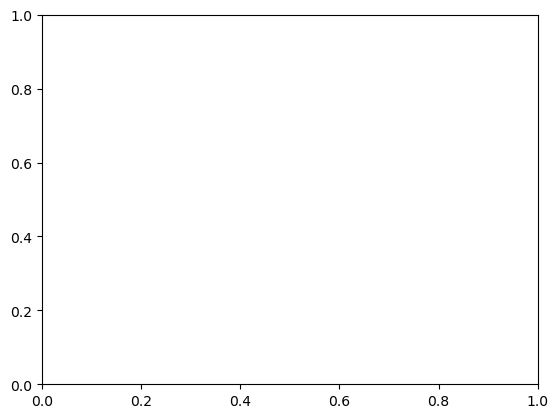

In [75]:
count_source_visit.hist(x="obj_index")

In [59]:
count_sources = dataJoined.groupby(by="obj_index").count()["psfFlux"]

<Axes: >

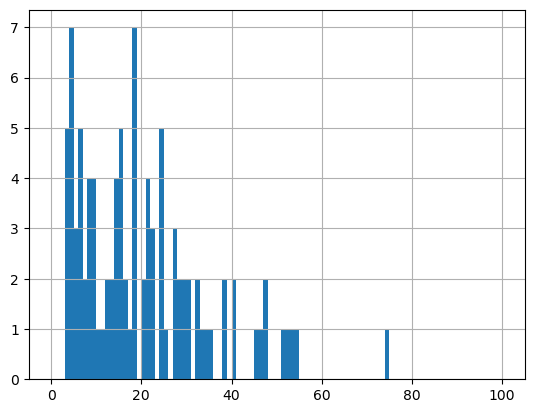

In [61]:
count_source.hist(bins=100,range=(0,100))

In [52]:
assert False

AssertionError: 

## Plot the per object source 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
nBins = 16 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-400, 400)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
dataJoined.columns

In [ ]:
Band_To_Cmap_Dict = {"g":plt.cm.Greens,"r":plt.cm.Reds,"i":plt.cm.Oranges,"z":plt.cm.Purples,"y":plt.cm.Greys}

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,100), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax1.set_ylim(-100, 100)
ax1.legend(fontsize=8)
ax1.grid()

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,100),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax2.set_ylim(-10, 10)
ax2.legend(fontsize=8)
ax2.grid()
if doSaveFigs:
    filename = "{}psfFluxDiffHist2D_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-20, 20)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
all_nightObs = dataJoined["nightObs"].unique() 
all_X = []
all_Y1 = []
all_EY1 = []
all_Y2 = []
all_EY2 = []
for night in all_nightObs:
    cut = dataJoined["nightObs"] == night
    df_sel = dataJoined[cut]
    pwv = df_sel["PWV"].mean()
    Y1 = df_sel["psfMagDiffMmag"].mean()
    EY1= df_sel["psfMagDiffMmag"].std()
    Y2 = df_sel["psfMagDiffChi"].mean()
    EY2 = df_sel["psfMagDiffChi"].std()
    all_X.append(pwv)
    all_Y1.append(Y1)
    all_EY1.append(EY1)
    all_Y2.append(Y2)
    all_EY2.append(EY2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)
ax1.errorbar(all_X,all_Y1,yerr=all_EY1,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax1.set_ylim(-50, 50)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")
ax2.errorbar(all_X,all_Y2,yerr=all_EY2,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)     

In [ ]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

In [ ]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} : {} {}sec".format(iObj,visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

In [ ]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
    ax.set_title(title)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

In [ ]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]

fig, axes = plt.subplots(4, 1, figsize=(14, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
suptitle = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
plt.suptitle(suptitle)
plt.tight_layout()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)

In [ ]:
airmasses = [airmassDict[v] for v in sorted_visitList if v in airmassDict.keys() ]
zeropoints = [zeroPointDict[v] for v in sorted_visitList if v in zeroPointDict.keys()]
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(sorted_visits_mjd,airmasses,marker='o',lw=1,c="blue",label="airmass") 
ax.set_xlabel("MJD")
ax.set_ylabel("airmass")
ax2 =ax.twinx()
ax2.plot(sorted_visits_mjd,zeropoints,marker='o',lw=1,c="red",label="zeropoint")
ax2.set_ylabel("zero-point (mag)")
ax.legend(loc="upper left")
ax.set_ylim(1.,2)
ax.grid()
ax2.legend(loc="upper right")
suptitle = f"Airmass and zero point for tract {tract} in band {band} (AUXTEL)"
ax.set_title(suptitle)
#ax2.set_ylim(27,28.5)

## Difference vs PWV

## Save the sources

In [ ]:
dataJoined.to_csv(fullname_file_output_selectedsources)